### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 08 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 08 декабря, -4 балла после 08:30 15 декабря, -6 баллов после 08:30 22 декабря, -8 баллов после 08:30 29 декабря.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

In [2]:
class MyDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
        if criterion == 'gini':
            self.inform_crit = self.gini
        elif criterion == 'entropy':
            self.inform_crit = self.entropy
        elif criterion == 'misclass':
            self.inform_crit = self.misclass
            
    def misclass(self, p):
        return 1 - p.max(axis=1);
    
    def entropy(self, p):
        return - np.sum(p * np.log2(p + 0.00001), axis=1)
    
    def gini(self, p):
        return 1 - np.sum(p ** 2, axis=1)

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        # x - значения по признаку
        # сортируем Х и y
        sorted_indices = x.argsort()
        X_sort, y_sort = x[sorted_indices], y[sorted_indices]
        borders = int(self.min_samples_split / 2 - 1)
        #отсекаем объекты, по которым точно не пройдет граница разбиения
        if (borders != 0):
            y_borders = y_sort[borders: -borders]
        else:
            y_borders = y_sort
        #к индексам, в которых меняется метка класса, добавляем смещение, которое посчитали
        indices = np.where(y_borders[:-1] != y_borders[1:])[0] + (borders + 1)
        if len(indices) == 0:
            return np.inf, None # нет сменяемости класса вообще
        
        eq_count = indices - np.append([borders], indices[:-1])
        one_hot_code = np.zeros((indices.shape[0], self.num_class)) # строки - границы, столбцы - классы
        one_hot_code[np.arange(indices.shape[0]), y_sort[indices - 1]] = 1

        class_increments = one_hot_code * eq_count.reshape(-1, 1)
        class_increments[0] = class_increments[0] + np.bincount(y_sort[:borders], minlength=self.num_class)

        # количество классов слева и справа в разбиении 
        l_class_cnt = np.cumsum(class_increments, axis=0)
        r_class_cnt = np.bincount(y_sort, minlength=self.num_class) - l_class_cnt

        # количество объектов слева и справа в разбиении
        l_sizes = indices.reshape(l_class_cnt.shape[0], 1)
        r_sizes = y_sort.shape[0] - l_sizes

        unsertainty_l = self.inform_crit(l_class_cnt / l_sizes) * (l_sizes / (l_sizes+r_sizes)).T
        unsertainty_r = self.inform_crit(r_class_cnt / r_sizes) * (r_sizes / (l_sizes+r_sizes)).T
        unsertainty = unsertainty_l.T + unsertainty_r.T

        idx = np.argmin(unsertainty)
        
        start_idx = l_sizes[idx][0] # индекс с которого начинается граница
        
        # мера неопределенности и порог
        return unsertainty[idx], (X_sort[start_idx - 1] + X_sort[start_idx]) / 2.0

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        if ((len(y) < self.min_samples_split) or (depth >= self.max_depth)):
            self.tree[node_id] = (self.LEAF_TYPE, np.bincount(y).argmax(), np.bincount(y).astype(float) / len(y))
            return
        
        thresholds = np.array([self.__find_threshold(x[:, i], y) for i in range(x.shape[1])])

        feature_id = thresholds[:, 0].argmin()
        threshold = thresholds[feature_id, 1]
        
        if threshold == None:
            self.tree[node_id] = (self.LEAF_TYPE, np.bincount(y).argmax(), np.bincount(y).astype(float) / len(y))
        else:
            X_l, X_r, y_l, y_r = self.__div_samples(x, y, feature_id, threshold)
            if ((len(X_l) == 0) or (len(X_r) == 0)):
                self.tree[node_id] = (self.LEAF_TYPE, np.bincount(y).argmax(), np.bincount(y).astype(float) / len(y))
            else:
                self.tree[node_id] = (self.NON_LEAF_TYPE, feature_id, threshold)
                self.__fit_node(X_l, y_l, 2 * node_id + 1, depth + 1)
                self.__fit_node(X_r, y_r, 2 * node_id + 2, depth + 1)
            if self.criterion == 'misclass':
                uncert = (1 - np.max(np.sum(np.unique(y, return_counts=True)[1] / len(y))))
                uncert_l = (1 - np.max(np.sum(np.unique(y_l, return_counts=True)[1] / len(y))))
                uncert_r = (1 - np.max(np.sum(np.unique(y_r, return_counts=True)[1] / len(y))))
                self.feature_importances_[feature_id] += (len(y) * uncert - len(y_l)
                                                          * uncert_l - len(y_r) * uncert_r) / len(y)
            elif self.criterion == 'gini':
                uncert = (1 - np.sum(np.unique(y, return_counts=True)[1] ** 2 / len(y) ** 2))
                uncert_l = (1 - np.sum(np.unique(y_l, return_counts=True)[1] ** 2 / len(y_l) ** 2))
                uncert_r = (1 - np.sum(np.unique(y_r, return_counts=True)[1] ** 2 / len(y_r) ** 2))
                self.feature_importances_[feature_id] += (len(y) * uncert - len(y_l)
                                                          * uncert_l - len(y_r) * uncert_r) / len(y)
            elif self.criterion == 'entropy':
                uncert = - (np.sum((np.unique(y, return_counts=True)[1] / len(y)) 
                                   * np.log2(np.unique(y, return_counts=True)[1] / len(y))))
                uncert_l = - (np.sum((np.unique(y_l, return_counts=True)[1] / len(y_l))
                                     * np.log2(np.unique(y_l, return_counts=True)[1] / len(y_l))))
                uncert_r = - (np.sum((np.unique(y_r, return_counts=True)[1] / len(y_r))
                                     * np.log2(np.unique(y_r, return_counts=True)[1] / len(y_r))))
                self.feature_importances_[feature_id] += (len(y) * uncert - len(y_l)
                                                          * uncert_l - len(y_r) * uncert_r) / len(y)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.feature_importances_ = np.zeros(x.shape[1], dtype='float')
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.feature_importances_

In [3]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [34]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [35]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [36]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

0.9444444444444444

In [37]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.9444444444444444

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [40]:
%time clf.fit(X_train, y_train)

CPU times: user 1.67 ms, sys: 718 µs, total: 2.38 ms
Wall time: 1.43 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [41]:
%time my_clf.fit(X_train, y_train)

CPU times: user 14.9 ms, sys: 1.4 ms, total: 16.3 ms
Wall time: 15 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [42]:
df = pd.read_csv('./data/Speed Dating Data.csv', encoding='latin1')

In [43]:
df.shape

(8378, 195)

### Удалим ненужные признаки

In [44]:
df = df.iloc[:, :97]

In [45]:
df = df.drop(['id', 'idg', 'condtn', 'position', 'positin1', 'round', 'order',
             'partner', 'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'dec_o', 'attr_o', 'sinc_o', 
              'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o','met_o', 'field',
              'undergra', 'from', 'zipcode','career', 'sports','tvsports','exercise',
              'dining','museums','art','hiking','gaming','clubbing','reading','tv',
              'theater','movies','concerts','music','shopping','yoga', 'expnum'], axis=1)


### Предобработка

In [46]:
df = df.dropna(subset=['age'])
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
df.field_cd.astype(int)

0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       1
18       1
19       1
20       2
21       2
22       2
23       2
24       2
25       2
26       2
27       2
28       2
29       2
        ..
8348     8
8349     8
8350     8
8351     8
8352     8
8353     8
8354     8
8355     8
8356    18
8357    18
8358    18
8359    18
8360    18
8361    18
8362    18
8363    18
8364    18
8365    18
8366    18
8367    18
8368    18
8369    18
8370    18
8371    18
8372    18
8373    18
8374    18
8375    18
8376    18
8377    18
Name: field_cd, Length: 8283, dtype: int64

In [47]:
df.drop_duplicates('iid').mn_sat.isnull().sum()

342

Nan решил заменить на минимальную оценку

In [48]:
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float).fillna(1)

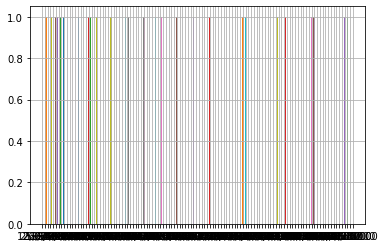

In [49]:
df.drop_duplicates('iid').tuition.hist()

In [50]:
df.drop_duplicates('iid').tuition.isnull().sum()

310

Большинство пропусков связано с тем, что университет находится не в штатах, но это тоже не точно как-то. Поэтому я в замешательстве. Возможно, если цена на обучение не указана, значит респондент учится на бюджетной основе, тогда можно заменить Nan на 0. Наверное, это самое логичное..

In [51]:
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float).fillna(0)

Положим Nan как other

In [52]:
df.race.fillna(6).astype(int)

0       4
1       4
2       4
3       4
4       4
5       4
6       4
7       4
8       4
9       4
10      2
11      2
12      2
13      2
14      2
15      2
16      2
17      2
18      2
19      2
20      2
21      2
22      2
23      2
24      2
25      2
26      2
27      2
28      2
29      2
       ..
8348    1
8349    1
8350    1
8351    1
8352    1
8353    1
8354    1
8355    1
8356    2
8357    2
8358    2
8359    2
8360    2
8361    2
8362    2
8363    2
8364    2
8365    2
8366    2
8367    2
8368    2
8369    2
8370    2
8371    2
8372    2
8373    2
8374    2
8375    2
8376    2
8377    2
Name: race, Length: 8283, dtype: int64

In [53]:
df.drop_duplicates('iid').imprace.isnull().sum()

1

In [54]:
df.drop_duplicates('iid').imprelig.isnull().sum()

1

Пустых значений мало - просто удалим

In [55]:
df = df.dropna(subset=['imprelig', 'imprace'])

In [56]:
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)
df.income

0       69487.0
1       69487.0
2       69487.0
3       69487.0
4       69487.0
5       69487.0
6       69487.0
7       69487.0
8       69487.0
9       69487.0
10      65929.0
11      65929.0
12      65929.0
13      65929.0
14      65929.0
15      65929.0
16      65929.0
17      65929.0
18      65929.0
19      65929.0
20          NaN
21          NaN
22          NaN
23          NaN
24          NaN
25          NaN
26          NaN
27          NaN
28          NaN
29          NaN
         ...   
8348    55138.0
8349    55138.0
8350    55138.0
8351    55138.0
8352    55138.0
8353    55138.0
8354    55138.0
8355    55138.0
8356        NaN
8357        NaN
8358        NaN
8359        NaN
8360        NaN
8361        NaN
8362        NaN
8363        NaN
8364        NaN
8365        NaN
8366        NaN
8367        NaN
8368        NaN
8369        NaN
8370        NaN
8371        NaN
8372        NaN
8373        NaN
8374        NaN
8375        NaN
8376        NaN
8377        NaN
Name: income, Length: 82

In [57]:
df.loc[:, 'income'] = df.loc[:, 'income'].fillna(-999)

In [58]:
df.goal.astype(int)
df = df.dropna(subset=['date'])
df.date.astype(int)
df.go_out.astype(int)

0       1
1       1
2       1
3       1
4       1
5       1
6       1
7       1
8       1
9       1
10      1
11      1
12      1
13      1
14      1
15      1
16      1
17      1
18      1
19      1
20      1
21      1
22      1
23      1
24      1
25      1
26      1
27      1
28      1
29      1
       ..
8348    3
8349    3
8350    3
8351    3
8352    3
8353    3
8354    3
8355    3
8356    1
8357    1
8358    1
8359    1
8360    1
8361    1
8362    1
8363    1
8364    1
8365    1
8366    1
8367    1
8368    1
8369    1
8370    1
8371    1
8372    1
8373    1
8374    1
8375    1
8376    1
8377    1
Name: go_out, Length: 8249, dtype: int64

In [59]:
df.career_c.isnull().sum()

59

In [60]:
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)

In [61]:
df.career_c

0       18.0
1       18.0
2       18.0
3       18.0
4       18.0
5       18.0
6       18.0
7       18.0
8       18.0
9       18.0
10      18.0
11      18.0
12      18.0
13      18.0
14      18.0
15      18.0
16      18.0
17      18.0
18      18.0
19      18.0
20      18.0
21      18.0
22      18.0
23      18.0
24      18.0
25      18.0
26      18.0
27      18.0
28      18.0
29      18.0
        ... 
8348     7.0
8349     7.0
8350     7.0
8351     7.0
8352     7.0
8353     7.0
8354     7.0
8355     7.0
8356    15.0
8357    15.0
8358    15.0
8359    15.0
8360    15.0
8361    15.0
8362    15.0
8363    15.0
8364    15.0
8365    15.0
8366    15.0
8367    15.0
8368    15.0
8369    15.0
8370    15.0
8371    15.0
8372    15.0
8373    15.0
8374    15.0
8375    15.0
8376    15.0
8377    15.0
Name: career_c, Length: 8249, dtype: float64

In [62]:
feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

In [63]:
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 99)
idx = ((temp.wave >= 6) & (temp.wave <= 9))

In [64]:
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)

In [65]:
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

In [66]:
feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 90) & (temp.totalsum != 0)
idx = ((temp.wave >= 6) & (temp.wave <= 9))
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

In [67]:
df = df.drop(['temp_totalsum'], axis=1)

In [68]:
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)

In [69]:
df = df.drop(['wave'], axis=1)

In [70]:
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
        
df_female.columns = df_female.columns + '_f'

In [71]:
df_female = df_female.drop(['pid_f'], axis=1)
df_pair = df_male.join(df_female.set_index('iid_f'), on='pid', how='inner')
df_pair = df_pair.drop(['iid', 'pid'], axis=1)

features = df_pair.columns[1:]

In [72]:
df_pair.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999 entries, 100 to 8377
Data columns (total 63 columns):
match         3999 non-null int64
int_corr      3999 non-null float64
samerace      3999 non-null int64
age           3999 non-null float64
field_cd      3999 non-null float64
mn_sat        3999 non-null float64
tuition       3999 non-null float64
race          3999 non-null float64
imprace       3999 non-null float64
imprelig      3999 non-null float64
income        3999 non-null float64
goal          3999 non-null float64
date          3999 non-null float64
go_out        3999 non-null float64
career_c      3999 non-null float64
exphappy      3999 non-null float64
attr1_1       3999 non-null float64
sinc1_1       3999 non-null float64
intel1_1      3999 non-null float64
fun1_1        3999 non-null float64
amb1_1        3999 non-null float64
shar1_1       3999 non-null float64
attr2_1       3999 non-null float64
sinc2_1       3999 non-null float64
intel2_1      3999 non-null flo

In [73]:
X = df_pair.iloc[:, 1:].values

In [74]:
y = df_pair.iloc[:, 0].values

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [230]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [231]:
my_clf.fit(X_train, y_train)

In [232]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [233]:
accuracy_score(my_clf.predict(X_test), y_test)

0.83375

In [234]:
f1_score(my_clf.predict(X_test), y_test, average='macro')

0.48278963051541174

In [235]:
f1_score(clf.predict(X_test), y_test, average='macro')

0.5436885889861062

In [236]:
accuracy_score(clf.predict(X_test), y_test)

0.735

# Валидация

In [237]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [238]:
crits = ('gini', 'entropy', 'misclass')
scores = []
for crit in crits:
    model = MyDecisionTreeClassifier(criterion=crit)
    scores.append(cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean())

In [239]:
scores

[0.026894266022918435, 0.02445634475033005, 0.02169312169312169]

In [240]:
criterion = crits[np.argmax(scores)]
criterion

'gini'

In [241]:
min_samples_split = np.arange(10, 20)
scores = []
for samples in min_samples_split:
    model = MyDecisionTreeClassifier(criterion=criterion, min_samples_split=samples)
    scores.append(cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean())

In [242]:
scores

[0.010346352247605013,
 0.010346352247605013,
 0.010346352247605013,
 0.010346352247605013,
 0.010346352247605013,
 0.010346352247605013,
 0.017302873986735447,
 0.017302873986735447,
 0.03130745064577435,
 0.03130745064577435]

In [243]:
min_samples_split = min_samples_split[np.argmax(scores)]
min_samples_split

18

In [244]:
depthes = np.arange(2, 20)
scores = []
for depth in depthes:
    model = MyDecisionTreeClassifier(criterion=criterion, min_samples_split=min_samples_split, max_depth=depth)
    scores.append(cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean())

In [245]:
scores

[0.0,
 0.010467980295566502,
 0.010778635778635779,
 0.03130745064577435,
 0.04222738942379122,
 0.05450565132490467,
 0.060645021320362556,
 0.06585177318601361,
 0.07123695831252068,
 0.07058881016437253,
 0.06967285231430227,
 0.06897268255862299,
 0.06897268255862299,
 0.06897268255862299,
 0.06897268255862299,
 0.06897268255862299,
 0.06897268255862299,
 0.06897268255862299]

In [246]:
max_depth = depthes[np.argmax(scores)]
max_depth

10

In [247]:
model = MyDecisionTreeClassifier(criterion=criterion, min_samples_split=min_samples_split, max_depth=max_depth)

In [248]:
model.fit(X_train, y_train)

In [249]:
f1_score(model.predict(X_test), y_test, average='macro')

0.5131194454395953

In [250]:
accuracy_score(y_pred=model.predict(X_test), y_true=y_test)

0.82375

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [255]:
model = MyDecisionTreeClassifier(criterion=criterion, min_samples_split=min_samples_split, max_depth=max_depth)
model.fit(X_train, y_train)

In [256]:
important_features = model.get_feature_importance()
list(features[np.argsort(important_features)[-10:]])

['shar1_1_f',
 'intel1_1',
 'field_cd_f',
 'shar2_1_f',
 'imprelig_f',
 'fun3_1_f',
 'field_cd',
 'exphappy_f',
 'income_f',
 'int_corr']

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

